<a href="https://colab.research.google.com/github/svsamsonov/ex2mcmc_new/blob/master/colab_notebooks/flex2mcmc_banana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ex2mcmc

In [2]:
from typing import Optional
from pathlib import Path
import numpy as np
import torch
from torch.distributions import MultivariateNormal as MNormal, Normal
from matplotlib import pyplot as plt
import seaborn as sns

from ex2mcmc.samplers import flex2mcmc, ex2mcmc
from ex2mcmc.models.rnvp_minimal import MinimalRNVP
from ex2mcmc.models.rnvp import RNVP
from ex2mcmc.utils.general_utils import IMGS_DIR, random_seed
from ex2mcmc.pyro_samplers import NUTS, HMC

sns.set_theme('talk', style="white")

In [3]:
from typing import Iterable, List

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde


def ema(series: Iterable, n: int) -> List:
    """
    returns an n period exponential moving average for
    the time series
    """
    series = np.array(series)
    ema = []
    j = 1

    # get n sma first and calculate the next n period ema
    sma = sum(series[:n]) / n
    multiplier = 2 / float(1 + n)
    ema.append(sma)

    # EMA(current) = ( (Price(current) - EMA(prev) ) x Multiplier) + EMA(prev)
    ema.append(((series[n] - sma) * multiplier) + sma)

    # now calculate the rest of the values
    for i in series[n + 1 :]:
        tmp = ((i - ema[j]) * multiplier) + ema[j]
        j = j + 1
        ema.append(tmp)

    return ema

def plot_result(
    chains, dist, flow=None, chain_id=0, grid_n=100, proj_dim1=-1, proj_dim2=-2
):
    proj_slice = [proj_dim1, proj_dim2]
    proj_dim1 = dist.dim + proj_dim1 + 1 if proj_dim1 < 0 else proj_dim1 + 1
    proj_dim2 = dist.dim + proj_dim2 + 1 if proj_dim2 < 0 else proj_dim2 + 1

    if flow:
        fig, axs = plt.subplots(1, 4, figsize=(17, 4))
    else:
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    result = chains.reshape(-1, chains.shape[-1])
    dist.plot_2d_countour(axs[0])
    xmin, xmax = axs[0].get_xlim()
    ymin, ymax = axs[0].get_ylim()

    axs[0].scatter(
        *result[:, proj_slice].T, alpha=min(0.6, 1000.0 / result.shape[0]), s=10
    )  # , c='r', marker='o')
    axs[0].set_title(f"Projected samples from {chains.shape[1]} chains")

    kernel = gaussian_kde(result[:, proj_slice].T)
    x = np.linspace(xmin, xmax, grid_n)
    y = np.linspace(ymin, ymax, grid_n)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])
    kde = np.reshape(kernel(positions).T, X.shape)
    axs[1].contour(X, Y, kde, cmap="inferno")
    axs[1].set_title(f"KDE")

    chain_id = 0
    result = chains[:, chain_id]
    dist.plot_2d_countour(axs[2])
    axs[2].plot(
        *result[:, proj_slice].T, "-", alpha=min(0.6, 1000.0 / result.shape[0])
    )  # , c='k')
    axs[2].set_title(f"Trajectory of chain {chain_id}")

    if flow:
        flow_sample = flow.sample((10000,)).detach().cpu()
        kernel = gaussian_kde(flow_sample[:, proj_slice].T)
        kde = np.reshape(kernel(positions).T, X.shape)
        axs[3].contour(X, Y, kde, cmap="inferno")
        axs[3].set_title(f"KDE of NF samples")

    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_xlabel(rf"$X{proj_dim1}$")
        ax.set_ylabel(rf"$X{proj_dim2}$")

    fig.tight_layout()

In [4]:
N_CHAINS = 1
N_SAMPLES = 1000
BURN_IN = 1000

PROJ_DIM1 = -2
PROJ_DIM2 = -1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class Banana(object):
    """
    """
    def __init__(self, dim: int, b: float, sigma: float):
        #self.q = q
        self.b = b
        self.sigma = sigma
        self._dim = dim
        #self.normal_even = Normal(1, 1)
        #self.normal_odd = Normal(0, q)

    @property
    def dim(self) -> int:
        return self._dim
    
    def log_prob(self, x: torch.FloatTensor) -> torch.FloatTensor:
        """
        Returns:
            log p(x)
        """
        even = np.arange(0, x.shape[-1], 2)
        odd = np.arange(1, x.shape[-1], 2)
        ll = -0.5*(x[..., odd] - self.b*x[..., even]**2 + (self.sigma**2)*self.b)**2 - ((x[..., even])**2)/(2*self.sigma**2)
        return ll.sum(-1)

        #return self.normal_even.log_prob(x[..., even]).sum(-1) + \
        #    self.normal_odd.log_prob(x[..., even] - x[..., odd] ** 2).sum(-1)

    def plot_2d_countour(self, ax):
        x = np.linspace(-10, 10, 100)
        y = np.linspace(-3, 3, 100)
        X, Y = np.meshgrid(x, y)
        inp = torch.from_numpy(np.stack([X, Y], -1))
        Z = self.log_prob(inp.reshape(-1, 2)).reshape(inp.shape[:-1])
        #levels = np.quantile(Z, np.linspace(0.9, 0.99, 5))

        ax.contour(X, Y, Z.exp(), 
                   #levels = levels,
                   levels=5,
                   alpha=1., cmap='inferno')

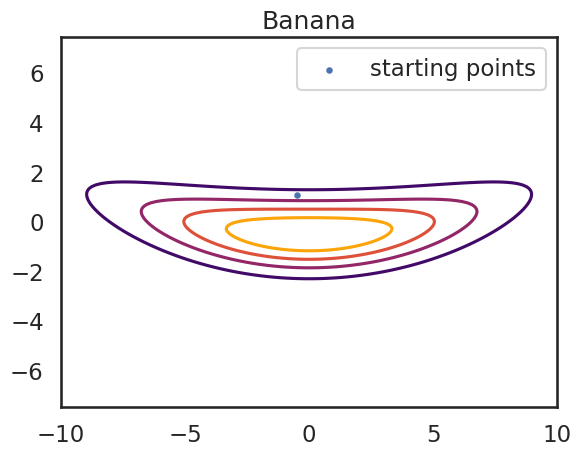

In [6]:
sigma_b = 5.0
banana_b = 0.02
dim = 100

banana = Banana(dim, banana_b, sigma_b)
ax = plt.subplot()
banana.plot_2d_countour(ax)

start_banana = torch.randn((N_CHAINS, banana.dim))
proj_slice = [PROJ_DIM1, PROJ_DIM2]
plt.scatter(*start_banana[:, proj_slice].T, s=10, label='starting points')
plt.title('Banana')
plt.legend()
plt.axis('equal')
plt.show()

In [7]:
step_size = 0.1

random_seed(42)

chains = NUTS(start_banana.to(device), banana, N_SAMPLES, BURN_IN, step_size=step_size, verbose=True)

Sample: 100%|██████████| 2000/2000 [01:26, 23.05it/s, step size=2.41e-01, acc. prob=0.895]


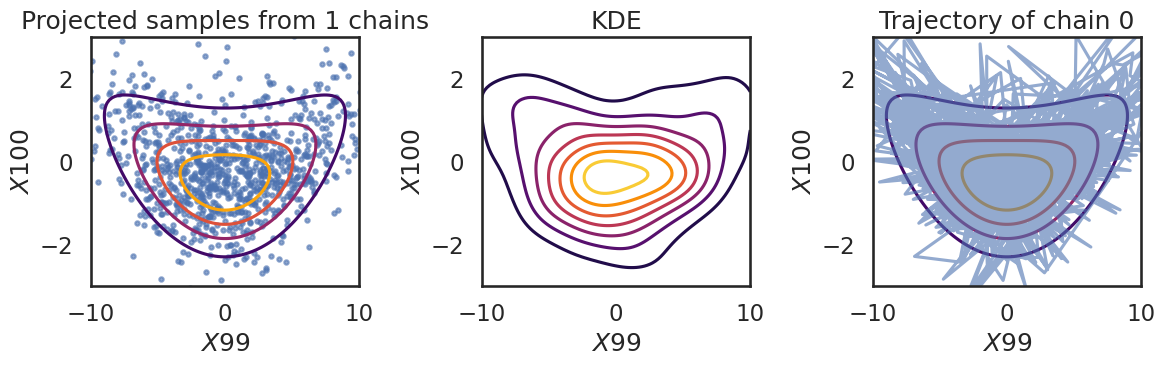

In [8]:
plot_result(chains.cpu(), banana, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'nuts_mog.png'))

Text(0.5, 1.0, 'NUTS samples')

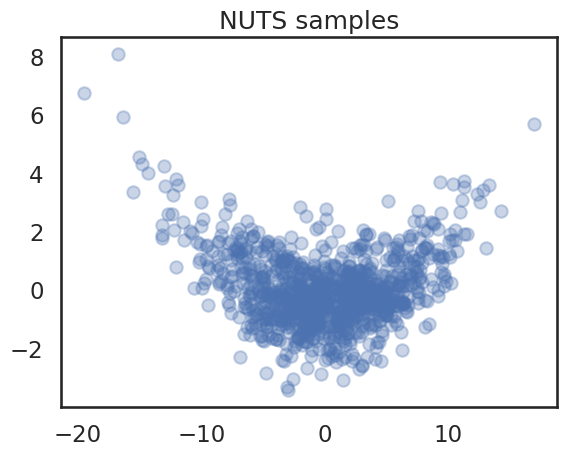

In [10]:
chains = chains.cpu()
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'NUTS samples')

In [50]:
step_size = 0.1
target_acceptance = 0.67
n_particles = 200
n_mala_steps = 5
train_steps = 1000
batch_size = 1000
prior_scale = 1
backward_kl_weight = 0.5
forward_kl_weight = 1 - backward_kl_weight

proposal = RNVP(num_blocks=4, dim=dim, device=device, scale=prior_scale)
opt = torch.optim.Adam(proposal.parameters(), 5e-4)
proposal.optim = opt
proposal.train()
proposal.scheduler = torch.optim.lr_scheduler.LambdaLR(
    opt, lambda it: int(it < train_steps)
)

random_seed(42)

# train
_, meta = flex2mcmc(
    proposal.prior.sample((batch_size,)),
    banana, 
    proposal, 
    1,
    train_steps,
    step_size=step_size, 
    n_particles=10,
    n_mala_steps=1,
    forward_kl_weight=forward_kl_weight,
    backward_kl_weight=backward_kl_weight,
    target_acceptance=target_acceptance,
    verbose=True)

proposal.eval();

KL forw 222.679,                      KL back -169.698 : 100%|██████████| 1001/1001 [00:29<00:00, 34.16it/s]


In [51]:
step_size = meta['step_size'][-1]
print(step_size)

0.05050679529955185


Text(0.5, 1.0, 'NF samples')

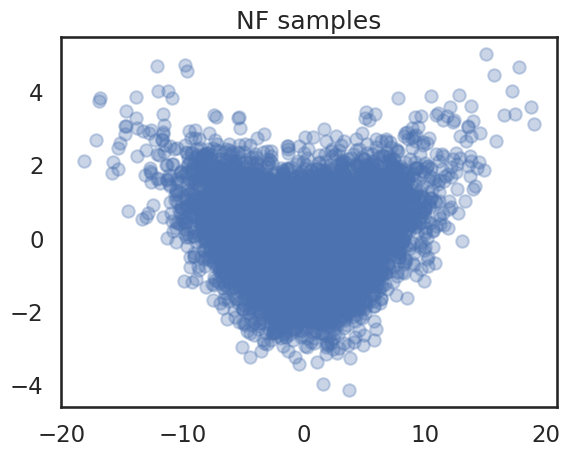

In [52]:
sample = proposal.sample((N_SAMPLES * 10,)).detach().cpu()
plt.scatter(sample.view(-1, dim)[:, PROJ_DIM1], sample.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title('NF samples')

In [53]:
# sample
# step_size = 0.1

chains, meta = flex2mcmc(
    start_banana.to(device), 
    banana, 
    proposal, 
    N_SAMPLES,
    BURN_IN,
    step_size=step_size, 
    n_particles=n_particles, 
    n_mala_steps=n_mala_steps, 
    target_acceptance=None,
    verbose=True)
chains = chains.detach().cpu()

100%|██████████| 2000/2000 [01:15<00:00, 26.37it/s]


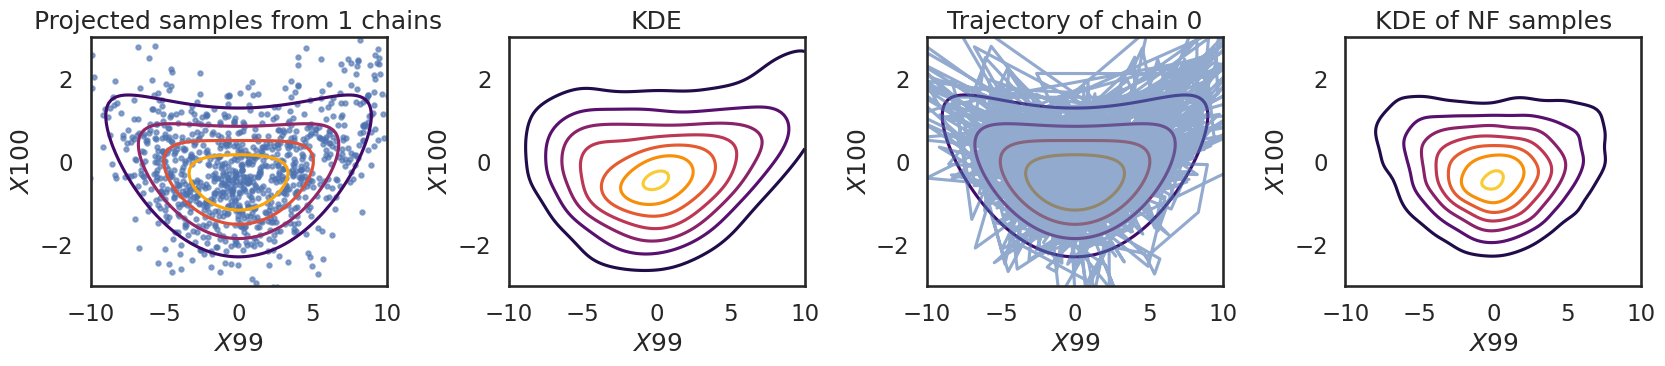

In [54]:
plot_result(chains.cpu(), banana, proposal, proj_dim1=PROJ_DIM1, proj_dim2=PROJ_DIM2)
# plt.savefig(Path(IMGS_DIR, 'flex_funnel.png'))

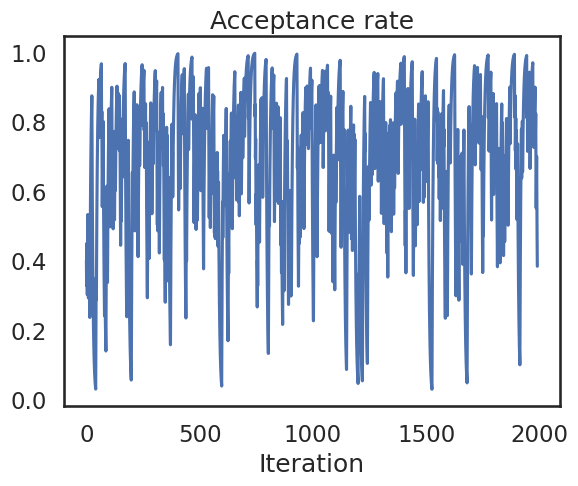

In [55]:
plt.plot(ema(meta['sir_accept'], 10))
plt.title('Acceptance rate')
plt.xlabel('Iteration')
plt.show()

Text(0.5, 1.0, 'FlEx$^2$MCM samples')

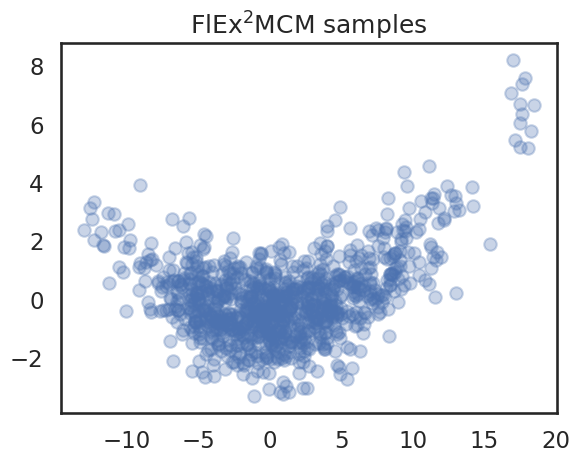

In [56]:
plt.scatter(chains.view(-1, dim)[:, PROJ_DIM1], chains.view(-1, dim)[:, PROJ_DIM2], alpha=0.3)
plt.title(r'FlEx$^2$MCM samples')